# Fit the ratio of resolved binaries over unresolved binaries of 3 different $q_{\rm lim}$ as a function of distance and use it to compute the total binary fraction and its uncertainties for the catalogue with MCMC unresolved BF results.

In [30]:
import os
import numpy as np
from scipy.stats import linregress
import astropy
from astropy.table import Table, vstack, join, hstack
from matplotlib import pyplot as plt
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14}
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

## 1. Counting resolved binaries in the GOG OC simulations

We first define a function that computes the unresolved binary fraction:

$$ f_b^{\rm resolved}(q>q_{lim}) = \frac{N_{\rm resolved\ systems\ with\ q>q_{lim}}}{N_{\rm all\ systems}}
= \frac{N_{\rm resolved\ systems\ with\ q>q_{lim}}}{N_{\rm resolved\ systems\ with\ q>q_{lim}} + N_{\rm unresolved\ systems\ with\ q>q_{lim}} + N_{\rm single\ stars}}$$

In [2]:
def compute_resolved_fb(simclus, qlim = 0.55):
    # Get systems: we use the Gaia file becasue this is how the OC would be seen if observed
    primaries   = ["A" in id for id in simclus["#ID"]]
    secondaries = ["B" in id for id in simclus["#ID"]]
    systems     = ["*" in id for id in simclus["#ID"]]
    # Compute mass ratios of the resolved systems
    # This works because both lists have the same length (for each component A there is the respective component B) and
    # because they have the same order: dividing their respective positions gives the ratios of components of the same
    # system
    massratios  = simclus["Mass"][secondaries] / simclus["Mass"][primaries]
    # Get number of resolved systems with q > qlim:
    Nsys_res_q_gtr_qlim = np.sum( massratios > qlim )
    # Get the number of all systems: the length of the catalogue minus the number of secondaries (found summing
    # all the list of True/False considering True=1 and False=0, and there is True when ID has a "B"):
    N_all = len(simclus) - np.sum(secondaries)
    # Return resolved fb:
    return np.round(Nsys_res_q_gtr_qlim / N_all, 3)


A similar function computes the resolved binary fraction:

$$ f_b^{\rm unresolved}(q>q_{lim}) = \frac{N_{\rm unresolved\ systems\ with\ q>q_{lim}}}{N_{\rm all\ systems}}
= \frac{N_{\rm unresolved\ systems\ with\ q>q_{lim}}}{N_{\rm resolved\ systems\ with\ q>q_{lim}} + N_{\rm unresolved\ systems\ with\ q>q_{lim}} + N_{\rm single\ stars}}$$

In [3]:
def compute_unresolved_fb(simclus_Gaia, simclus_UniversModel, qlim = 0.55):
    # Get systems: we use the Gaia file becasue this is how the OC would be seen if observed
    primaries_gaia   = ["A" in id for id in simclus_Gaia["#ID"]]
    secondaries_gaia = ["B" in id for id in simclus_Gaia["#ID"]]
    unresolved_systems     = ["*" in id for id in simclus_Gaia["#ID"]]
    
    # Compute mass ratios of the unresolved systems
    # This works because both lists have the same length (for each component A there is the respective component B) and
    # because they have the same order: dividing their respective positions gives the ratios of components of the same
    # system
    unresolved_systems_ids = list(simclus_Gaia["#ID"][unresolved_systems])
    massratios_unres_sys = []
    for ii in np.arange(0, len(unresolved_systems_ids)):
        primary = simclus_UniversModel["Mass"][ simclus_UniversModel["#ID"] == ((unresolved_systems_ids[ii])[:-1] + "A" )]
        secondary = simclus_UniversModel["Mass"][ simclus_UniversModel["#ID"] == ((unresolved_systems_ids[ii])[:-1] + "B" )]
        massratio = float(secondary)/(float(primary))
        massratios_unres_sys.append(massratio)

    massratios_unres_sys_col = astropy.table.Column(massratios_unres_sys)
    # Get number of unresolved systems with q > qlim:
    Nsys_unres_q_gtr_qlim = np.sum( massratios_unres_sys_col > qlim )
    # Get the number of all systems: the length of the catalogue minus the number of secondaries (found summing
    # all the list of True/False considering True=1 and False=0, and there is True when ID has a "B"):
    N_all = len(simclus_Gaia) - np.sum(secondaries_gaia)
    # Return unresolved fb:
    return np.round(Nsys_unres_q_gtr_qlim / N_all, 3)


## 2. Loop over simulated clusters and distances

We use custom GOG simulations of OC populations at different distances (created by E. Massana on May 27, 2022).
The assumed limiting resolution of Gaia is 500 mas.

In [7]:
simdir = "data/OC_sims_distances/"

cluslist = ["Alessi_21", "ASCC_21", "Ruprecht_147", "UPK_53"]
distances= [50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]  # in pc

In [8]:
# Create empty arrays
# They have len(cluslist) elements, each of them being a list consisting of len(distances) values which contain the
# resolved binary fraction for each of the 10 distances for that OC and that q_lim.
fb_res_qlim049 = np.zeros((len(cluslist), len(distances)))
fb_res_qlim06 = np.zeros((len(cluslist), len(distances)))
fb_res_qlim065 = np.zeros((len(cluslist), len(distances)))

fb_unres_qlim049 = np.zeros((len(cluslist), len(distances)))
fb_unres_qlim06 = np.zeros((len(cluslist), len(distances)))
fb_unres_qlim065 = np.zeros((len(cluslist), len(distances)))

In [9]:
# For each OC
for ii in np.arange(len(cluslist)):
    print("Analysing simulations of ", cluslist[ii])
    # For each distance:
    for jj in np.arange(len(distances)):
        # Read simulation
        simcOC_gaia = Table.read(simdir + cluslist[ii] + "_isochrone_m_10000_" + 
                             str(distances[jj]) + "_Gaia.csv", format="csv")
        simOC_UniversModel = Table.read(simdir + cluslist[ii] + "_isochrone_m_10000_" + 
                             str(distances[jj]) + "_UniversModel.csv", format="csv")
        # Compute fb_resolved
        fb_res_qlim049[ii, jj] = compute_resolved_fb(simcOC_gaia, qlim = 0.49)  # MCMC 10th percentile
        fb_res_qlim06[ii, jj]  = compute_resolved_fb(simcOC_gaia, qlim = 0.6)   # MCMC median
        fb_res_qlim065[ii, jj] = compute_resolved_fb(simcOC_gaia, qlim = 0.65)  # MCMC 90th percentile
        # Compute fb_unresolved
        fb_unres_qlim049[ii, jj] = compute_unresolved_fb(simcOC_gaia, simOC_UniversModel, qlim = 0.49)
        fb_unres_qlim06[ii, jj]  = compute_unresolved_fb(simcOC_gaia, simOC_UniversModel, qlim = 0.6)
        fb_unres_qlim065[ii, jj] = compute_unresolved_fb(simcOC_gaia, simOC_UniversModel, qlim = 0.65)

Analysing simulations of  Alessi_21
Analysing simulations of  ASCC_21
Analysing simulations of  Ruprecht_147
Analysing simulations of  UPK_53


# $q_{lim}=0.6$ (median for the selected simulated OCs studied through MCMC)

In [10]:
distances_all = []
fb_res_06_all = []
fb_unres_06_all = []
ratio_fb_res_over_unres = []
for ii in np.arange(0, 4):
    for jj in np.arange(0, len(distances)):
        distances_all.append(np.log10(distances[jj]))
        fb_res_06_all.append(fb_res_qlim06[ii][jj])
        fb_unres_06_all.append(fb_unres_qlim06[ii][jj])
        ratio_fb_res_over_unres.append(fb_res_qlim06[ii][jj]/fb_unres_qlim06[ii][jj])

\Quadratic fit for all 4 OCs: y=a·x^2+b·x+c
  a: 0.16635556281903421 +- 0.01884632908632048
  b: -1.1683799046724241 +- 0.09390577558453594
  c: 2.1355268933311566 +- 0.11293056179722583


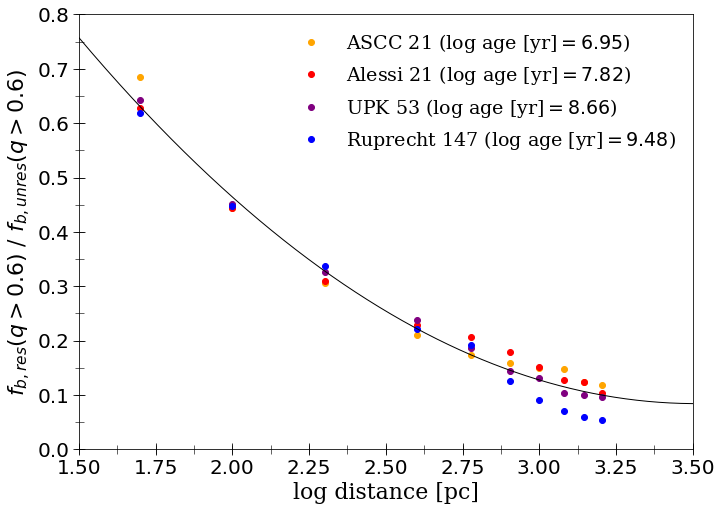

In [13]:
xpts = np.log10(distances)

coeffs_all, covariance_matrix_all = np.polyfit(distances_all, ratio_fb_res_over_unres, 2, full=False, cov=True)
all_fit = np.poly1d(coeffs_all)
a_06 = coeffs_all[0]
b_06 = coeffs_all[1]
c_06 = coeffs_all[2]
print("\Quadratic fit for all 4 OCs: y=a·x^2+b·x+c")
print("  a:", a_06, "+-", np.sqrt(covariance_matrix_all[0][0]))
print("  b:", b_06, "+-", np.sqrt(covariance_matrix_all[1][1]))
print("  c:", c_06, "+-", np.sqrt(covariance_matrix_all[2][2]))

fig = plt.figure(frameon=True)
ax  = plt.subplot(111)
fig.set_size_inches(11,8)  #(width, height)
xpts_linearfits = np.linspace(1.5, 3.5, 1000)
plt.plot(xpts, fb_res_qlim06[1]/fb_unres_qlim06[1], marker="o", markersize=6, linewidth=0, color="orange", label=r"ASCC 21 (log age [yr]$=6.95$)")
plt.plot(xpts, fb_res_qlim06[0]/fb_unres_qlim06[0], marker="o", markersize=6, linewidth=0, color="red", label=r"Alessi 21 (log age [yr]$=7.82$)")
plt.plot(xpts, fb_res_qlim06[3]/fb_unres_qlim06[3], marker="o", markersize=6, linewidth=0, color="purple", label=r"UPK 53 (log age [yr]$=8.66$)")
plt.plot(xpts, fb_res_qlim06[2]/fb_unres_qlim06[2], marker="o", markersize=6, linewidth=0, color="blue", label=r"Ruprecht 147 (log age [yr]$=9.48$)")
plt.plot(xpts_linearfits, all_fit(xpts_linearfits), color="black", linewidth=1.0, label='_nolegend_')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('log distance [pc]',  fontsize = 22, fontdict=font)
plt.ylabel('${f_{b,res}(q>0.6)}$ / ${f_{b,unres}(q>0.6)}$',  fontsize = 22, fontdict=font)
plt.xlim(1.5, 3.5)
plt.ylim(0.0, 0.8)
#plt.xscale('log')
ax.tick_params(which="major", direction='inout', length=12.)
ax.tick_params(which="minor", direction='inout', length=9.)
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

font_legend = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=19)
plt.legend(fontsize=21, prop=font_legend, framealpha=0.)
plt.savefig("im/fb_res_qlarger06_4OCs_logdist_fitdeg2.png")
plt.show()

# $q_{lim}=0.49$ ($16^{\rm th}$ percentile for the selected simulated OCs studied through MCMC)

In [14]:
distances_all = []
fb_res_049_all = []
fb_unres_049_all = []
ratio_fb_res_over_unres_049 = []
for ii in np.arange(0, 4):
    for jj in np.arange(0, len(distances)):
        distances_all.append(np.log10(distances[jj]))
        fb_res_049_all.append(fb_res_qlim049[ii][jj])
        fb_unres_049_all.append(fb_unres_qlim049[ii][jj])
        ratio_fb_res_over_unres_049.append(fb_res_qlim049[ii][jj]/fb_unres_qlim049[ii][jj])

Quadratic fit for all 4 OCs: y=a·x^2+b·x+c
  a: 0.15723006168359083 +- 0.019244090928333218
  b: -1.146448037697483 +- 0.09588770713741603
  c: 2.155218324791002 +- 0.1153140216250924


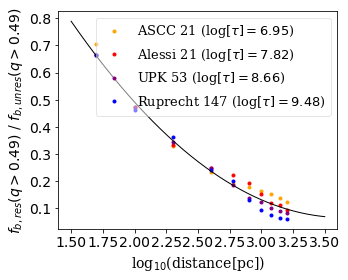

In [17]:
xpts = np.log10(distances)

coeffs_all, covariance_matrix_all = np.polyfit(distances_all, ratio_fb_res_over_unres_049, 2, full=False, cov=True)
all_fit = np.poly1d(coeffs_all)
a_049 = coeffs_all[0]
b_049 = coeffs_all[1]
c_049 = coeffs_all[2]
print("Quadratic fit for all 4 OCs: y=a·x^2+b·x+c")
print("  a:", a_049, "+-", np.sqrt(covariance_matrix_all[0][0]))
print("  b:", b_049, "+-", np.sqrt(covariance_matrix_all[1][1]))
print("  c:", c_049, "+-", np.sqrt(covariance_matrix_all[2][2]))

fig = plt.figure(frameon=True)
fig.set_size_inches(5,4)  #(width, height)
xpts_linearfits = np.linspace(1.5, 3.5, 1000)
plt.plot(xpts, fb_res_qlim049[1]/fb_unres_qlim049[1], marker="o", markersize=3, linewidth=0, color="orange", label=r"ASCC 21 (log[$\tau]=6.95$)")
plt.plot(xpts, fb_res_qlim049[0]/fb_unres_qlim049[0], marker="o", markersize=3, linewidth=0, color="red", label=r"Alessi 21 (log[$\tau]=7.82$)")
plt.plot(xpts, fb_res_qlim049[3]/fb_unres_qlim049[3], marker="o", markersize=3, linewidth=0, color="purple", label=r"UPK 53 (log[$\tau]=8.66$)")
plt.plot(xpts, fb_res_qlim049[2]/fb_unres_qlim049[2], marker="o", markersize=3, linewidth=0, color="blue", label=r"Ruprecht 147 (log[$\tau]=9.48$)")
plt.plot(xpts_linearfits, all_fit(xpts_linearfits), color="black", linewidth=1.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('log$_{10}$(distance[pc])', fontdict=font)
plt.ylabel('${f_{b,res}(q>0.49)}$ / ${f_{b,unres}(q>0.49)}$', fontdict=font)
font_legend = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=13)
plt.legend(fontsize=13, prop=font_legend, framealpha=0.5)
#plt.savefig("im/fb_res_qlarger049_4OCs_logdist_fitdeg2.png")
plt.show()

# $q_{lim}=0.65$ ($84^{\rm th}$ percentile for the selected simulated OCs studied through MCMC)

In [18]:
distances_all = []
fb_res_065_all = []
fb_unres_065_all = []
ratio_fb_res_over_unres_065 = []
for ii in np.arange(0, 4):
    for jj in np.arange(0, len(distances)):
        distances_all.append(np.log10(distances[jj]))
        fb_res_065_all.append(fb_res_qlim065[ii][jj])
        fb_unres_065_all.append(fb_unres_qlim065[ii][jj])
        ratio_fb_res_over_unres_065.append(fb_res_qlim065[ii][jj]/fb_unres_qlim065[ii][jj])

Quadratic fit for all 4 OCs: y=a·x^2+b·x+c
  a: 0.16331281582693938 +- 0.020092271909656952
  b: -1.1436128517950548 +- 0.10011394623800941
  c: 2.088678257309876 +- 0.12039647318835926


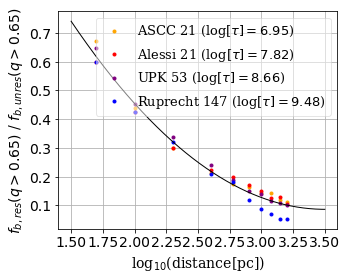

In [19]:
xpts = np.log10(distances)

coeffs_all, covariance_matrix_all = np.polyfit(distances_all, ratio_fb_res_over_unres_065, 2, full=False, cov=True)
all_fit = np.poly1d(coeffs_all)
a_065 = coeffs_all[0]
b_065 = coeffs_all[1]
c_065 = coeffs_all[2]
print("Quadratic fit for all 4 OCs: y=a·x^2+b·x+c")
print("  a:", a_065, "+-", np.sqrt(covariance_matrix_all[0][0]))
print("  b:", b_065, "+-", np.sqrt(covariance_matrix_all[1][1]))
print("  c:", c_065, "+-", np.sqrt(covariance_matrix_all[2][2]))

fig = plt.figure(frameon=True)
fig.set_size_inches(5,4)  #(width, height)
xpts_linearfits = np.linspace(1.5, 3.5, 1000)
plt.plot(xpts, fb_res_qlim065[1]/fb_unres_qlim065[1], marker="o", markersize=3, linewidth=0, color="orange", label=r"ASCC 21 (log[$\tau]=6.95$)")
plt.plot(xpts, fb_res_qlim065[0]/fb_unres_qlim065[0], marker="o", markersize=3, linewidth=0, color="red", label=r"Alessi 21 (log[$\tau]=7.82$)")
plt.plot(xpts, fb_res_qlim065[3]/fb_unres_qlim065[3], marker="o", markersize=3, linewidth=0, color="purple", label=r"UPK 53 (log[$\tau]=8.66$)")
plt.plot(xpts, fb_res_qlim065[2]/fb_unres_qlim065[2], marker="o", markersize=3, linewidth=0, color="blue", label=r"Ruprecht 147 (log[$\tau]=9.48$)")
plt.plot(xpts_linearfits, all_fit(xpts_linearfits), color="black", linewidth=1.0) 
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('log$_{10}$(distance[pc])', fontdict=font)
plt.ylabel('${f_{b,res}(q>0.65)}$ / ${f_{b,unres}(q>0.65)}$', fontdict=font)
font_legend = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=13)
plt.legend(fontsize=13, prop=font_legend, framealpha=0.5)
#plt.savefig("im/fb_res_qlarger065_4OCs_logdist_fitdeg2.png")
plt.show()

## 3. Adding unresolved and total binary fractions to the simulated catalogue

In [37]:
# Catalogue of the 324 simulated OCs:
cat_sim = Table.read("data/Catalogue_simulated_324OCs.fits", format="fits")

We compute the total binary fraction according to the following formulae:

![Formulae_image](Formulae_fb_tot.png)

In [39]:
# Columns with the ratios of resolved over unresolved BF of the q>q_lim in each case, for the simulated CMDs:
cat_sim['fb_res_grt06_over_fb_unres_grt06']  = a_06 * ((np.log10(cat_sim["DistPc"]))**2) + \
                                                        b_06 *  (np.log10(cat_sim["DistPc"])) + c_06
cat_sim['fb_res_grt065_over_fb_unres_grt065']= a_065* ((np.log10(cat_sim["DistPc"]))**2) + \
                                                        b_065*  (np.log10(cat_sim["DistPc"])) + c_065
cat_sim['fb_res_grt049_over_fb_unres_grt049']= a_049* ((np.log10(cat_sim["DistPc"]))**2) + \
                                                        b_049*  (np.log10(cat_sim["DistPc"])) + c_049
# Column of the median and percentiles of the total BF:
cat_sim['mean_fb_tot_greater06'] = cat_sim["mean_fb_50"] * \
                                            (1.0 + cat_sim["fb_res_grt06_over_fb_unres_grt06"])
cat_sim['mean_fb_tot_greater065']= np.sqrt(  (cat_sim["mean_fb_sigu"] * 
                                                       (1.0 + cat_sim["fb_res_grt06_over_fb_unres_grt06"]))**2 
                                                    + (cat_sim["mean_fb_50"] * 
                                                       (abs(cat_sim["fb_res_grt065_over_fb_unres_grt065"] 
                                                            - cat_sim["fb_res_grt06_over_fb_unres_grt06"])))**2
                                                    )
cat_sim['mean_fb_tot_greater049']= np.sqrt(  (cat_sim["mean_fb_sigl"] * 
                                                       (1.0 + cat_sim["fb_res_grt06_over_fb_unres_grt06"]))**2 
                                                    + (cat_sim["mean_fb_50"] * 
                                                       (abs(cat_sim["fb_res_grt06_over_fb_unres_grt06"] 
                                                            - cat_sim["fb_res_grt049_over_fb_unres_grt049"])))**2
                                                    )


In [40]:
cat_sim.write("data/Catalogue_simulated_324OCs.fits", format="fits", overwrite=True)

## 4. Use the same formulae to calculate the total binary fractions for the observed catalogue
### a.k.a. create the final catalogue

First we read the data tables: the Cantat-Gaudin+2020 catalogue + the results of our binary fraction analysis:

In [31]:
# Cantat-Gaudin+2020 catalogue (Table 1)
nntable = Table.read("data/CantatGaudin2020_table1.fits")
nntable["Cluster"]  = np.array([np.char.strip(a, ' ') for a in nntable["Cluster"]], dtype="S17")
# Results of our analysis (separate files for the Tarricq+ and Cantat+ membership lists:
tarricqres = Table.read("data/mcmc_results_tarricq_summary.fits")
cantatres  = Table.read("data/mcmc_results_cantat_summary.fits")
# Join the two subtables
jointres   = vstack([tarricqres, cantatres])
jointres["Cluster"] = np.array([np.char.strip(a, ' ') for a in jointres["clus"]], dtype="S17")
# Merge the catalogues
mergedtable = join(nntable, jointres, join_type='inner')
print("We have (non-curated) binary fraction results for", len(mergedtable), "OCs")

We have (non-curated) binary fraction results for 379 OCs


Clean the results by imposing cuts in $\sigma_{\rm BS}$, $\sigma_{\rm MS}$, and $\Delta G$:

* $\sigma_{\rm BS}   \leq 0.25$
* $\sigma_{\rm BS}   \leq 0.2$
* $|\Delta G + 0.75| \leq 0.05$

In [32]:
ok         = (mergedtable["sB_50"] <= 0.25) * \
             (mergedtable["sM_50"] <= 0.20) * (abs(mergedtable["DG_50"]+0.75) <= 0.05)
finaltable = mergedtable[ok]

Calculate the binary fractions corrected for resolved binaries:

In [41]:
# Columns with the ratios of resolved over unresolved BF of the q>q_lim in each case, for the simulated CMDs:
finaltable['fb_res_grt06_over_fb_unres_grt06']  = a_06 * ((np.log10(finaltable["DistPc"]))**2) + \
                                                        b_06 *  (np.log10(finaltable["DistPc"])) + c_06
finaltable['fb_res_grt065_over_fb_unres_grt065']= a_065* ((np.log10(finaltable["DistPc"]))**2) + \
                                                        b_065*  (np.log10(finaltable["DistPc"])) + c_065
finaltable['fb_res_grt049_over_fb_unres_grt049']= a_049* ((np.log10(finaltable["DistPc"]))**2) + \
                                                        b_049*  (np.log10(finaltable["DistPc"])) + c_049
# Column of the median and percentiles of the total BF:
finaltable['fb_tot_qlim06'] = finaltable["fb_50"] * (1.0 + finaltable["fb_res_grt06_over_fb_unres_grt06"])
finaltable['fb_tot_qlim06_sigu']= np.sqrt(( finaltable["fb_sigu"] * 
                                           (1.0 + finaltable["fb_res_grt06_over_fb_unres_grt06"]) )**2 
                                         + (finaltable["fb_50"] * 
                                           (abs(finaltable["fb_res_grt065_over_fb_unres_grt065"] 
                                                - finaltable["fb_res_grt06_over_fb_unres_grt06"])))**2  )
finaltable['fb_tot_qlim06_sigl']= np.sqrt(( finaltable["fb_sigl"] * 
                                           (1.0 + finaltable["fb_res_grt06_over_fb_unres_grt06"]) )**2 
                                         + (finaltable["fb_50"] * 
                                           (abs(finaltable["fb_res_grt06_over_fb_unres_grt06"] 
                                                - finaltable["fb_res_grt049_over_fb_unres_grt049"])))**2  )


Save the final table:

In [42]:
finaltable.write("data/Catalogue_observed_251_OCs_binaryfraction.fits", overwrite=True)